<a href="https://colab.research.google.com/github/FabriDeCastelli/ISPR-23-24/blob/main/assignment1/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: Time Series Analysis - Air Quality

## Author: Fabrizio De Castelli

### 1. Data Preprocessing
Some basic data preprocessing to prepare the dataset for the analysis. Includes loading the dataset, filtering the columns, imputing missing values, and standardizing the dataset. The dataset is then visualized to better understand the upcoming analysis.

#### 1.1 Load the dataset drop useless columns
The dataset is loaded and the columns are filtered to keep only the sensors and the ground truths. The ground truths are the columns with the suffix 'GT'. The sensors are the columns with the suffix 'S' followed by a number.
All columns have been converted to float and the missing values have been replaced with None. The NMHC(GT) column has been dropped as it contains too many missing values.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import sys
import os

current_dir = %pwd

parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

!git clone https://github.com/FabriDeCastelli/ISPR-23-24.git
os.chdir("ISPR-23-24")


Cloning into 'ISPR-23-24'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 44 (delta 13), reused 39 (delta 10), pack-reused 0
Receiving objects: 100% (44/44), 3.90 MiB | 9.58 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [4]:
# load the dataset, replace commas with dots, and show the first 10 rows
df = pd.read_csv('assignment1/dataset/AirQualityUCI.csv', sep=';')
df = df.replace(",", ".", regex=True)
df.head(5)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [5]:
# ground truths
ground_truths = df.filter(regex='(GT)')
ground_truths = ground_truths.astype(float)
ground_truths = ground_truths.replace(-200, None)

# drop NMHC(GT) column as there are too many missing values
ground_truths = ground_truths.drop(columns=['NMHC(GT)'])

# sensors
sensors = df.filter(regex='S\d')
sensors = sensors.replace(-200, None)

# show columns with missing values and their number in a dataframe
missing_values = ground_truths.isin([None]).sum()
missing_values = pd.concat([missing_values, sensors.isin([None]).sum()])
missing_values

CO(GT)           1684
C6H6(GT)          366
NOx(GT)          1639
NO2(GT)          1642
PT08.S1(CO)       366
PT08.S2(NMHC)     366
PT08.S3(NOx)      366
PT08.S4(NO2)      366
PT08.S5(O3)       366
dtype: int64

#### 1.2 Imputation and standardization missing values
Linear interpolation is used to impute missing values. This is done by taking the mean of the previous and next value. The dataset is then standardized by subtracting the column's mean from each column. The variance is not included in the standardization as it is not necessary for the upcoming analysis.

In [6]:
def imputation(dataframe):
    """
    Impute missing values with the mean of the previous and next value.
    Done via linear interpolation.

    :param dataframe: the dataframe to impute
    :return: the imputed dataframe
    """
    for column in dataframe.columns[dataframe.isin([None]).any()]:
        dataframe[column] = dataframe[column].astype(float).interpolate()
    return dataframe

def standardization(dataframe):
    """
    Standardize the dataframe.

    :param dataframe: the dataframe to standardize
    :return: the standardized dataframe
    """
    for column in dataframe.columns:
        dataframe[column] = dataframe[column].astype(float)
        dataframe[column] -= dataframe[column].mean()
    return dataframe

sensors = imputation(sensors)
sensors = standardization(sensors)
ground_truths = imputation(ground_truths)
ground_truths = standardization(ground_truths)

# assert that there are no missing values
assert sensors.isin([None]).sum().sum() == 0
assert ground_truths.isin([None]).sum().sum() == 0

#### 1.4 Statistics: starting and ending day and time of measurements
To better understand the upcoming analysis, it is important to know the starting and ending day and time of the measurements. The first measurement has been done in the rush hour (traffic peak): the sensors can capture pollution the most.

In [7]:
first_day = df["Date"].iloc[df["Date"].first_valid_index()]
print(f'Measurements starting day: {pd.to_datetime(first_day).day_name()}, {first_day}, '
      f'time: {df["Time"].iloc[df["Time"].first_valid_index()]}')

last_day = df["Date"].iloc[df["Date"].last_valid_index()]
print(f'Measurements ending day: {pd.to_datetime(last_day).day_name()}, {last_day}, '
        f'time: {df["Time"].iloc[df["Time"].last_valid_index()]}')



Measurements starting day: Sunday, 10/03/2004, time: 18.00.00
Measurements ending day: Monday, 04/04/2005, time: 14.00.00


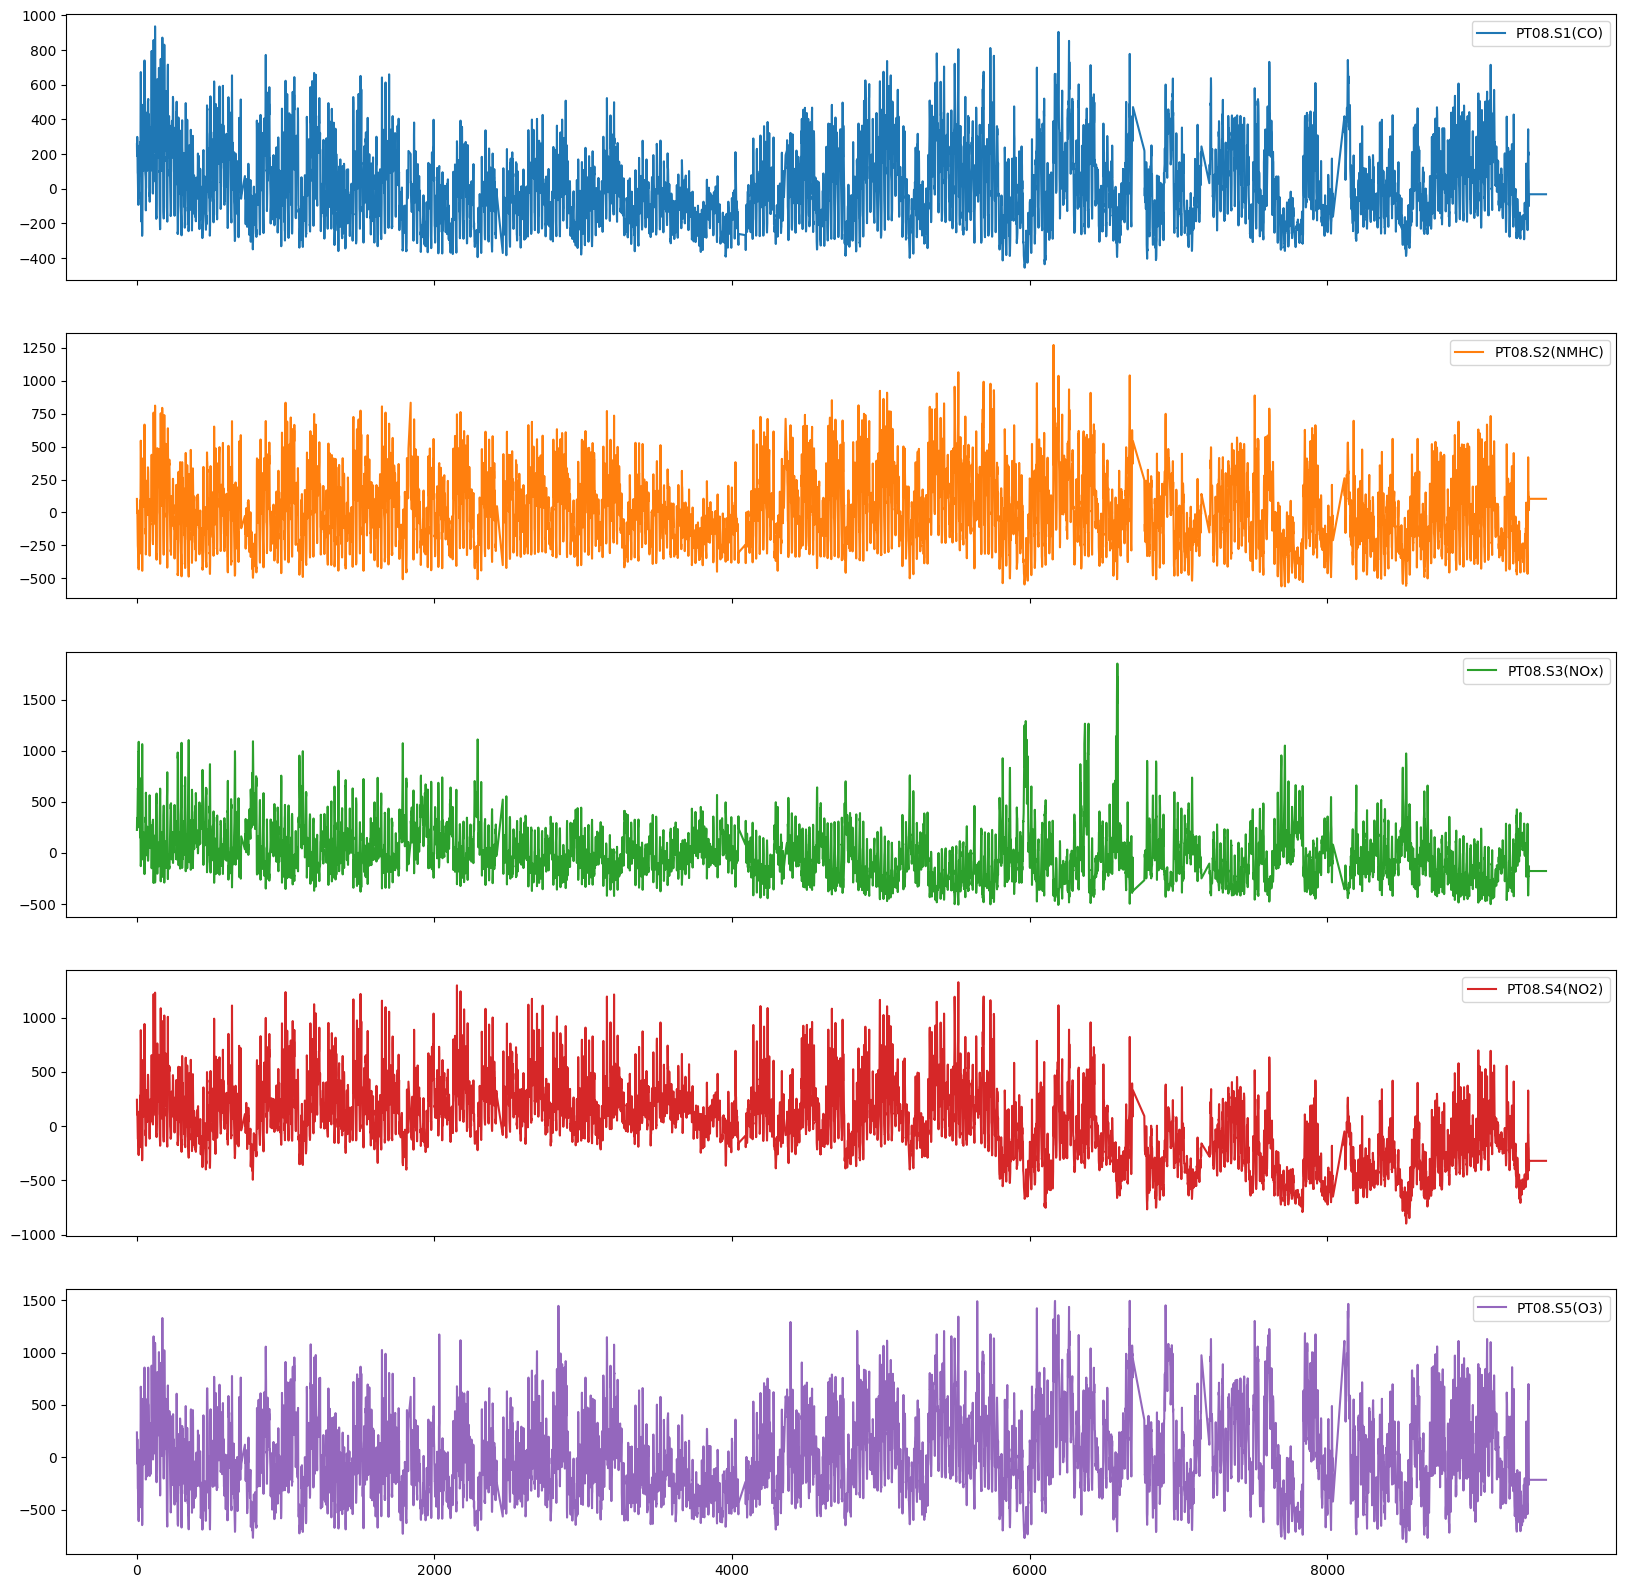

In [8]:
sensors.plot(subplots=True, figsize=(20, 20))
plt.show()

## Some utility functions

In [9]:
def normalized_cross_correlation(x, y, lag):
    """
    Computes the normalized cross-correlation between two time series, for a given lag.

    :param x: the first time series
    :param y: the second time series
    :param lag: the lag
    :return: the normalized cross-correlation
    """
    return cross_correlation(x, y, lag) / (np.linalg.norm(x) * np.linalg.norm(y))

def cross_correlation(x, y, lag):
    """
    Computes the cross-correlation between two time series, for a given lag.

    :param x: the first time series
    :param y: the second time series
    :param lag: the lag
    :return: the cross-correlation
    """
    range_ = slice(max(0, lag), min(len(x), len(x) + lag))
    return np.dot(np.roll(x, -lag)[range_], y[range_])

def plot_cross_correlation(correlations, sensor1, sensor2, lags, show=True, save=True):
    """
    Plots the cross-correlation between all the columns of the dataframe.

    :param correlations: the normalized cross-correlations
    :param sensor1: the first sensor's name
    :param sensor2: the second sensor's name
    :param lags: the lags at which the cross-correlation was computed
    :param show: whether to show the plot
    :param save: whether to save the plot
    """
    assert save or show

    # plot with seaborn
    plt.figure(figsize=(10, 5))
    sns.set_context('paper')
    sns.set_style('whitegrid')
    sns.lineplot(x=lags, y=correlations)
    plt.title(f'{sensor1} vs {sensor2}')
    plt.xlabel('Lag')
    plt.ylabel('Cross - Correlation')
    plt.axhline(0, color='red', lw=1, linestyle='--')
    if save:
        if "GT" in sensor1:
            path = 'results/ground_truths'
        else:
            path = 'results/sensors'
        if not os.path.exists(path):
            os.makedirs(path)
        plt.savefig(f'{path}/{sensor1}_vs_{sensor2}.png')
    if show:
        plt.show()
    plt.close()

def save_all_pairs(dataframe, lags):

    for i, column1 in enumerate(dataframe.columns):
        for j, column2 in enumerate(dataframe.columns):
            correlations = [
                normalized_cross_correlation(dataframe[column1], dataframe[column2], lag)
                for lag in lags
            ]
            plot_cross_correlation(correlations, column1, column2, lags, show=False)


### 2. Cross-Correlation
Cross-correlation: measure of similarity between two time series as a function of the lag of one relative to the other. It is defined as:

$$
\phi_{x_1x_2}(\tau) = \sum_{t=\max(0, \tau)}^{N + \min(0, \tau) - 1} x_1(t - \tau)x_2(t)
$$

where $\tau$ is the lag, $N$ is the length of the two time series, $x_1$ and $x_2$ are the time series. The normalized cross-correlation, instead, is defined as:

$$
\bar{\phi}_{x_1x_2}(\tau) = \frac{\phi_{x_1x_2}(\tau)}{\sqrt{{\displaystyle \sum_{t=1}^{N}} (x_1(t))^2} \sqrt{{\displaystyle \sum_{t=1}^{N}} (x_2(t))^2}}
$$

It can be helpful for the analysis to plot the auto-correlation of a time series, which is its cross-correlation with itself.

$$
\rho_{x_1}(\tau) = \phi_{x_1x_1}(\tau)
$$

In [10]:
WEEK_HOURS = 7 * 24
num_weeks = 3
taus = range(-num_weeks * WEEK_HOURS, num_weeks * WEEK_HOURS + 1)

# saves the cross-correlation between all pairs of sensors
save_all_pairs(sensors, taus)
# same for ground truths
save_all_pairs(ground_truths, taus)

### 3. Results
In this analysis we ony propose the (normalized) Cross-Correlation between two pairs of sensors. It is computed for a range of lags from -504 to 504, the equivalent of the hours of two times 3 weeks.

#### 3.1 Cross-Correlation between S1(CO) and S3(NOx)
The first pair is S1(CO), which measures Carbon Monoxide, and S3(NOx), which measures Nitrogen Oxides:
1. The cross-correlation (in module) is highest at a lag of 0, which can be expected since the sensors measure something that can be very correlated at the same time.
2. Each local peak in the cross-correlation happens at an interval of 24 hours, meaning that every day the two sensors are measuring some elements that might be correlated. Since the time series starts at 18:00, we have that each peak happens at the same time for the following days and this can be interpreted as the "rush hour" at which most of the cars are on the road.
3. This analysis shows that these two sensors are measuring chemicals that are inversely correlated, as confirmed by  [this paper](https://www.sciencedirect.com/science/article/pii/S0196890404000494): _"an increase of NOx emission is accompanied by a decrease of CO emission, the two phenomena being antagonistic"_. Of course, this is a general statement and the cross-correlation is not a causation, but it is interesting to see that the data supports this theory, even if the reference paper does not involve measurements of air pollution caused by traffic.
4. The strength of the correlation of these sensors is not very high, but suggests the presence of a relationship between the two chemicals.

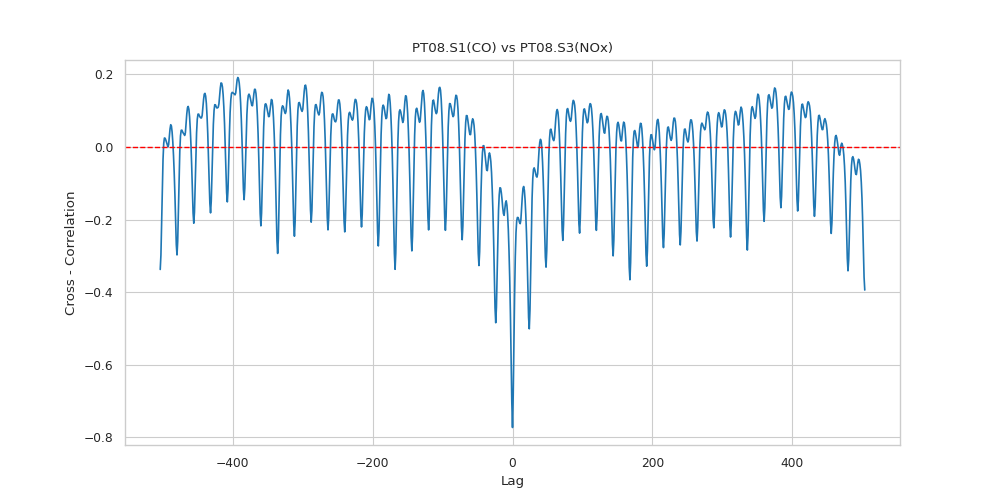

In [11]:
display(Image(filename='results/sensors/PT08.S1(CO)_vs_PT08.S3(NOx).png'))

#### 3.2 Cross-Correlation between S4(NO2) and S2(NMHC)
The second pair is S4(NO2), which measures Nitrogen Dioxide, and S2(NMHC), which measures Non-Methane Hydrocarbons:
1. As for the previous comparison, the cross-correlation is highest at a lag of 0.
2. The cross-correlation is a little bit stronger than the previous one, but still not very high. We can infer it is higher from the plot: the peaks are higher in module than the previous ones.
3. The chemicals measured by these sensors are not inversely correlated as the previous ones.

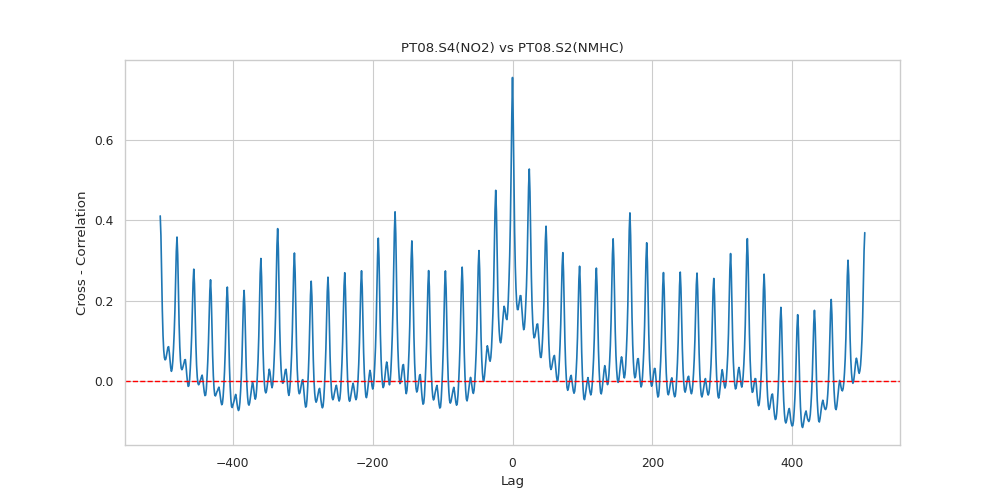

In [12]:
display(Image(filename='results/sensors/PT08.S4(NO2)_vs_PT08.S2(NMHC).png'))

#### 3.3 Cross-Correlation between S4(NO2) and S5(O3)
In this case we have a weaker cross-correlation between the two sensors (with respect to the previous experiments). The cross-correlation is close to 0 for all lags, even if we can see the same trend as always in which the strength increases for lags that are multiples of 24.


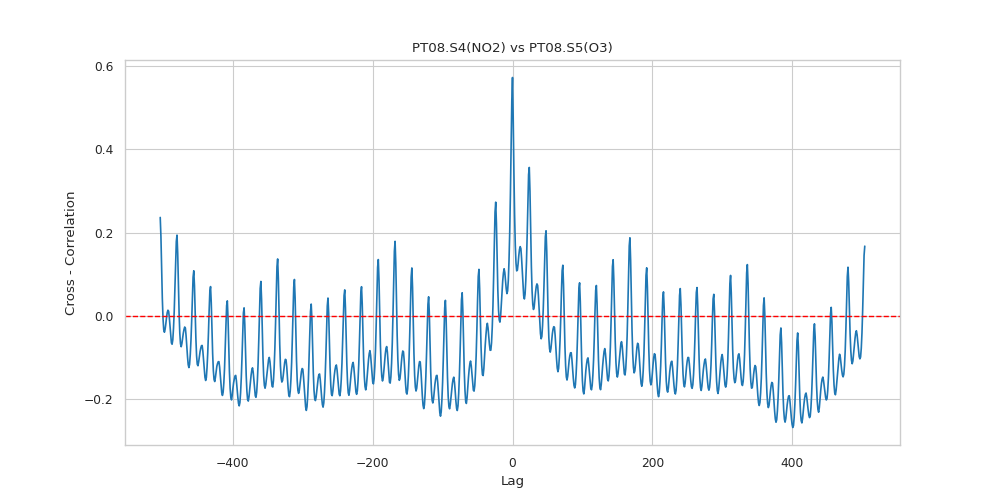

In [13]:
display(Image(filename='results/sensors/PT08.S4(NO2)_vs_PT08.S5(O3).png'))

#### 3.4 Auto-Correlation of S4(NO2)
It is interesting to plot the Auto-Correlation of a signal. Among all signals we chose to plot the Auto-Correlation of S4(NO2), which measures Nitrogen Dioxide, because it has higher auto-correlation than the other sensors. Even if for the analysis it was not required to plot the auto-correlation, here are some considerations:
1. The auto-correlation is 1 at a lag of 0, as expected.
2. The trend is still the same as the previous plots, with peaks at multiples of 24.
3. Since NO2 is produced mostly by the combustion process of diesel engines (mostly trucks, buses and so on..., [source](https://www.lung.org/clean-air/outdoors/what-makes-air-unhealthy/nitrogen-dioxide)), a possible interpretation of this plot is that in proximity of the sensor many vehicles implementing this type of engine are passing. We are not sure about this but the consistency in measurements of this sensor suggests that more or less a regular amount of NO2 is produced every day.

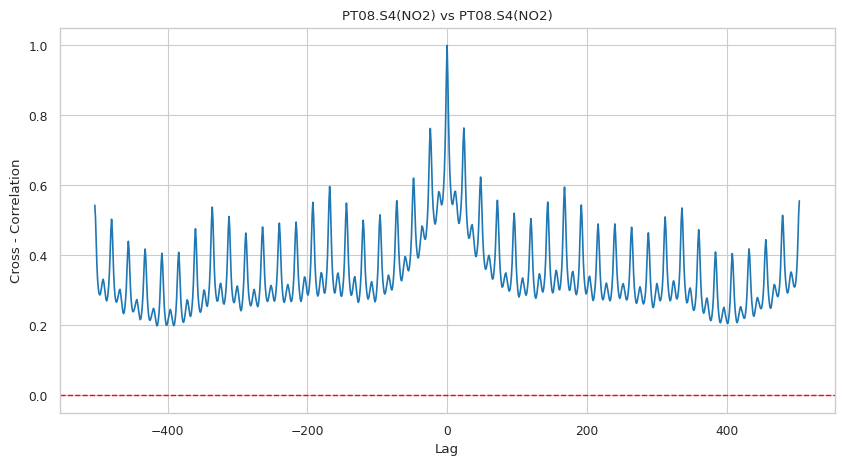

In [14]:
plot_cross_correlation(
    [normalized_cross_correlation(sensors['PT08.S4(NO2)'], sensors['PT08.S4(NO2)'], lag)
     for lag in taus],
    'PT08.S4(NO2)',
    'PT08.S4(NO2)',
    taus,
    save=False)

#### 3.5 Cross-Correlation between S1(CO) and CO(GT)
The last comparison is between the sensor S1(CO) and its ground truth CO(GT). What is curious about this plot is that we expect the sensor to be correlated positively with the ground truth, but the cross-correlation is negative for the majority of lags. Moreover, since for $\tau = 0$ the Cross-Correlation is the correlation of the perfectly aligned signals, that it is slightly bigger than 0.1, it is an index of poor correlation. Here are some possible motivations:
1. The sensor is not very accurate or the ground truth is not very reliable.
2. The sensor is measuring something that is not exactly the same as the ground truth, maybe sensitive to other pollutants.
3. The location of the sensor that generated the ground truth has been placed in a place which was not really affected the same way by the pollution that the sensor was measuring. In the dataset description: _"Ground Truths ... were provided by a co-located reference certified analyzer"_, so we don't know if the sensor was placed in the same place as the ground truth.

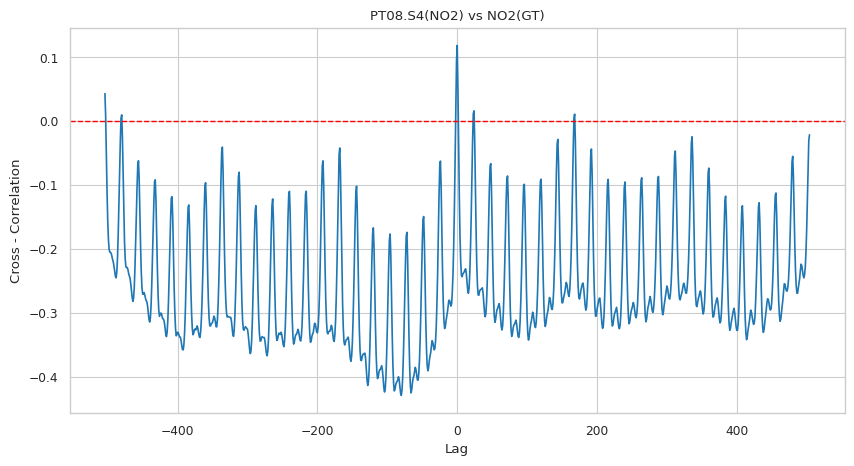

In [15]:
plot_cross_correlation(
    [normalized_cross_correlation(sensors['PT08.S4(NO2)'], ground_truths['NO2(GT)'], lag)
     for lag in taus],
    'PT08.S4(NO2)',
    'NO2(GT)',
    taus,
    save=False)

### 4. Conclusions
We know that the dataset is built on top of measurements at road level of air pollution in an italian city. More or less all sensors are correlated, but not all of them are strongly. We examined the correlation between S1 and S3, which are inversely correlated, but their correlation is not very strong as overall. The same goes for S4 and S2, which are not inversely correlated and exhibit a stronger (not that much) correlation. Then, we plotted a case in which what we measured appeared to be weaker than the previous cases, which is the cross-correlation between S4 and S5, but still being consistent with the trend we are expecting: the peaks are at multiples of 24. As second to last experiment, we plotted the auto-correlation of S4, which is the sensor that measures Nitrogen Dioxide. The auto-correlation is consistent with the previous plots and suggests that the sensor is measuring a regular amount of NO2 every day, of course with peaks during the rush hour.

The analysis has been done for lags of 3 weeks, which is a reasonable amount of time to capture the behaviour of the sensors. Lags could have been chosen for all the time series we decided to focus on a smaller time span to shift the focus on meaningful patterns in the signals, assuming that for larger taus the analysis is very similar to the one we did.

To conclude: even if the examination and hence interpretation of these Cross-Correlation is influenced by the noise in the data, we still managed to get interpretable results. To analyze and goo deeper in the analysis, we should study the behaviour of these chemical considering other environmental factors, such as temperature, humidity and weather (for example wind speed). But with the used tools we witnessed that the sensors are measuring something which is somehow correlated as overall and that the measurements are aligned with what we can say to be intuitive about air quality in a (possibly big) city, measured at road level.